# Variable Augmented Network for Invertible MR Coil Compression on Kspace Domain

This is a demo of Variable Augmented Network for Invertible MR Coil Compression on Kspace Domain(VAN-ICC-K). The demo shows how to use of alignment of the matrices. The exapmle is on 2D data and it is a deep learning method for coil compression. This demo demonstrates effective compression from 12 to 4 virtual channels.

# Import Package

In [1]:
import numpy as np
import os, time, random
import argparse
import json
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from model.model import InvISPNet
from dataset.mri_dataset import mriDataset12and4_real_imag_cross
from config.config import get_arguments
from skimage.measure import compare_psnr, compare_ssim
from scipy.io import savemat, loadmat
from matplotlib import pyplot as plt

In [2]:
parser = get_arguments()
parser.add_argument("--out_path", type=str, default="./exps/", help="Path to save checkpoint. ")
parser.add_argument("--resume", dest='resume', action='store_true',  help="Resume training. ")
parser.add_argument("--loss", type=str, default="L1", choices=["L1", "L2"], help="Choose which loss function to use. ")
parser.add_argument("--lr", type=float, default=0.0001, help="Learning rate")
parser.add_argument("--epoch", type=int, default=5000, help="Learning epuch")
parser.add_argument("--aug", dest='aug', action='store_true', help="Use data augmentation.")
args = parser.parse_args(args=[])

os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.makedirs(args.out_path, exist_ok=True)
os.makedirs(args.out_path+"%s" % args.task, exist_ok=True)
os.makedirs(args.out_path+"%s/checkpoint" % args.task, exist_ok=True)

with open(args.out_path+"%s/commandline_args.yaml" % args.task, 'w') as f:
    json.dump(args.__dict__, f, indent=2)

# SOS Loss

In [3]:
def sos_torch_24(img_tensor):
    # # 全部平方
    # [1, 24, 256, 256] = img_tensor**2
    # # 一对相加 变为24通道
    # [1, 24, 256, 256] = plus()
    # # sqrt + 平方
    # [1, 24, 256, 256] = (sqrt())**2
    # # sum / 2
    # [1, 1, 256, 256] = sum(axis=1)/2
    # # sqrt
    # [1, 1, 256, 256] = sqrt()
    tensor_square = torch.FloatTensor(1, 24, 256, 256)
    tensor_square = torch.mul(img_tensor, img_tensor)
    tensor_sum = torch.FloatTensor(1, 12, 256, 256)
    for i in range(0, int(2 * tensor_sum.size()[1]), 2):
        tensor_sum[:, int(i / 2), :, :] = tensor_square[:, i, :, :] + tensor_square[:, i + 1, :, :]
    tensor_sum_all = torch.FloatTensor(1, 1, 256, 256)
    tensor_sum_all = torch.sum(tensor_sum, dim=1)
    tensor_sqrt = torch.FloatTensor(1, 1, 256, 256)
    tensor_sqrt = torch.sqrt(tensor_sum_all)
    tensor_sqrt = tensor_sqrt.cuda()
    return tensor_sqrt

In [4]:
def sos_torch_st(img_tensor, st, sum_num):
    # # 全部平方
    # [1, 24, 256, 256] = img_tensor**2
    # # 一对相加 变为24通道
    # [1, 24, 256, 256] = plus()
    # # sqrt + 平方
    # [1, 24, 256, 256] = (sqrt())**2
    # # sum / 2
    # [1, 1, 256, 256] = sum(axis=1)/2
    # # sqrt
    # [1, 1, 256, 256] = sqrt()
    tensor_square = torch.FloatTensor(1, 24, 256, 256).cuda()
    tensor_square = torch.mul(img_tensor, img_tensor)
    tensor_sum = torch.FloatTensor(1, sum_num, 256, 256).cuda()
    for i in range(0, int(2 * tensor_sum.size()[1]), 2):
        tensor_sum[:, int(i / 2), :, :] = torch.add(tensor_square[:, i + int(st), :, :],
                                                    tensor_square[:, i + 1 + int(st), :, :])
    tensor_sum_all = torch.FloatTensor(1, 1, 256, 256).cuda()
    tensor_sum_all = torch.sum(tensor_sum, dim=1)
    tensor_sqrt = torch.FloatTensor(1, 1, 256, 256).cuda()
    tensor_sqrt = torch.sqrt(tensor_sum_all)
    tensor_sqrt = tensor_sqrt.cuda()
    return tensor_sqrt

# Train

In [5]:
def main(args):
    net = InvISPNet(channel_in=24, channel_out=24, block_num=8)
    net.cuda()
    if args.resume:
        net.load_state_dict(torch.load(args.out_path+"%s/checkpoint/latest.pth" % args.task))
        print("[INFO] loaded " + args.out_path+"%s/checkpoint/latest.pth" % args.task)
    optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[(i+1)*25 for i in range((args.epoch)//25-1)], gamma=0.5)
    print("[INFO] Start data loading and preprocessing")
    mri_dataset = mriDataset12and4_real_imag_cross(root1='/home/lqg/文档/duibi/data_brain/train_data/train_12coil_zengqiang/train_12ch', root2='/home/lqg/文档/duibi/data_brain/train_data/train_2coil_SCC', root='/home/lqg/文档/duibi/data_brain/train_data/train_12coil_zengqiang/train_12ch')
    dataloader = DataLoader(mri_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)

    print("[INFO] Start to train")
    step = 0
    for epoch in range(args.epoch):
        epoch_time = time.time()
        i = 0
        for i_batch, sample_batched in enumerate(dataloader):
            step_time = time.time()
            input_c12_mri, output_c12_mri, input_c2x2x6 = sample_batched['input_channel24_mri'].cuda(), sample_batched['target_channel24_mri'].cuda(), sample_batched['input_channel8x3_mri'].cuda()
            
            # net forward
            forward_compress_all = net(input_c12_mri)
            # average
            forward_compress = (forward_compress_all[:, 0:8, :, :] + forward_compress_all[:, 8:16, :, :] + forward_compress_all[:, 16:24, :, :]) / 3
            # for
            tensor_temp1 = torch.ones([1, forward_compress.size()[1] // 2, forward_compress.size()[2], forward_compress.size()[3]]).cuda()
            tensor_kdata_forward = torch.complex(tensor_temp1, tensor_temp1)
            for i in range(0, forward_compress.size()[1], 2):
                tensor_kdata_forward[0, int(i/2), :, :] = torch.complex(forward_compress[0, i, :, :], forward_compress[0, i+1, :, :])
            
            tensor_temp2 = torch.ones([1, forward_compress.size()[1] // 2, forward_compress.size()[2], forward_compress.size()[3]]).cuda()
            tensor_img_forward = torch.complex(tensor_temp2, tensor_temp2)
            for i in range(forward_compress.size()[1] // 2):
                tensor_img_forward[0, i, :, :] = torch.fft.ifft2(tensor_kdata_forward[0, i, :, :])
            
            tensor_img_forward_cross = torch.FloatTensor(1, forward_compress.size()[1], forward_compress.size()[2], forward_compress.size()[3]).cuda()
            for i in range(0, forward_compress.size()[1], 2):
                tensor_img_forward_cross[0, i, :, :] = torch.real(tensor_img_forward[0, int(i/2), :, :])
                tensor_img_forward_cross[0, i+1, :, :] = torch.imag(tensor_img_forward[0, int(i/2), :, :])  
            
            # ori
            tensor_temp3 = torch.ones([1, input_c12_mri.size()[1] // 2, input_c12_mri.size()[2], input_c12_mri.size()[3]]).cuda()
            tensor_kdata_ori = torch.complex(tensor_temp3, tensor_temp3)
            for i in range(0, input_c12_mri.size()[1], 2):
                tensor_kdata_ori[0, int(i/2), :, :] = torch.complex(input_c12_mri[0, i, :, :], input_c12_mri[0, i+1, :, :])
                
            tensor_temp4 = torch.ones([1, input_c12_mri.size()[1] // 2, input_c12_mri.size()[2], input_c12_mri.size()[3]]).cuda()
            tensor_img_ori = torch.complex(tensor_temp4, tensor_temp4)
            for i in range(input_c12_mri.size()[1] // 2):
                tensor_img_ori[0, i, :, :] = torch.fft.ifft2(tensor_kdata_ori[0, i, :, :])
                
            tensor_img_ori_cross = torch.FloatTensor(1, input_c12_mri.size()[1], input_c12_mri.size()[2], input_c12_mri.size()[3]).cuda()
            for i in range(0, input_c12_mri.size()[1], 2):
                tensor_img_ori_cross[0, i, :, :] = torch.real(tensor_img_ori[0, int(i/2), :, :])
                tensor_img_ori_cross[0, i+1, :, :] = torch.imag(tensor_img_ori[0, int(i/2), :, :])
                
            # forward loss   
            sos_forward = sos_torch_st(tensor_img_forward_cross, 0, 4)         
            sos_ori = sos_torch_24(tensor_img_ori_cross)
            sos_forward_loss = F.smooth_l1_loss(sos_forward, sos_ori)
            
            # net backward
            backward_recovery = net(forward_compress_all, rev=True)           
            # back
            tensor_temp5 = torch.ones([1, backward_recovery.size()[1] // 2, backward_recovery.size()[2], backward_recovery.size()[3]]).cuda()
            tensor_kdata_back = torch.complex(tensor_temp5, tensor_temp5)
            for i in range(0, backward_recovery.size()[1], 2):
                tensor_kdata_back[0, int(i/2), :, :] = torch.complex(backward_recovery[0, i, :, :], backward_recovery[0, i+1, :, :])
                
            tensor_temp6 = torch.ones([1, backward_recovery.size()[1] // 2, backward_recovery.size()[2], backward_recovery.size()[3]]).cuda()
            tensor_img_back = torch.complex(tensor_temp6, tensor_temp6)
            for i in range(backward_recovery.size()[1] // 2):
                tensor_img_back[0, i, :, :] = torch.fft.ifft2(tensor_kdata_back[0, i, :, :])
                
            tensor_img_backward_cross = torch.FloatTensor(1, backward_recovery.size()[1], backward_recovery.size()[2], backward_recovery.size()[3]).cuda()
            for i in range(0, backward_recovery.size()[1], 2):
                tensor_img_backward_cross[0, i, :, :] = torch.real(tensor_img_back[0, int(i/2), :, :])
                tensor_img_backward_cross[0, i+1, :, :] = torch.imag(tensor_img_back[0, int(i/2), :, :])
            
            # backward loss
            sos_backward_loss = F.smooth_l1_loss(tensor_img_backward_cross, sos_ori)
                
            # backprogapation
            loss = sos_forward_loss + sos_backward_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print("Epoch: %d Step: %d || loss: %.10f sos_forward_loss:  %.10f || lr: %f time: %f"%(
                epoch, step, loss.detach().cpu().numpy(), sos_forward_loss.detach().cpu().numpy(), optimizer.param_groups[0]['lr'], time.time()-step_time)) 
            step += 1
            i = i + 1
        torch.save(net.state_dict(), args.out_path+"%s/checkpoint/latest.pth" % args.task)
        if (epoch+1) % 1 == 0:
            torch.save(net.state_dict(), args.out_path+"%s/checkpoint/%04d.pth" % (args.task, epoch))
            print("[INFO] Successfully saved "+args.out_path+"%s/checkpoint/%04d.pth" % (args.task, epoch))
        scheduler.step()
        print("[INFO] Epoch time: ", time.time()-epoch_time, "task: ", args.task)
        
if __name__ == '__main__':
    torch.set_num_threads(4)
    main(args)

[INFO] Start data loading and preprocessing
[INFO] Start to train


/home/lqg/miniconda3/envs/INCC/lib/python3.6/site-packages/ipykernel_launcher.py:82: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 24, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 0 Step: 0 || loss: 4.7549695969 sos_forward_loss:  4.7102174759 || lr: 0.000100 time: 0.584947
Epoch: 0 Step: 1 || loss: 4.3919358253 sos_forward_loss:  4.3403663635 || lr: 0.000100 time: 0.425139
Epoch: 0 Step: 2 || loss: 4.2392849922 sos_forward_loss:  4.1994094849 || lr: 0.000100 time: 0.471292
Epoch: 0 Step: 3 || loss: 5.3583636284 sos_forward_loss:  5.2991485596 || lr: 0.000100 time: 0.422107
Epoch: 0 Step: 4 || loss: 3.9701468945 sos_forward_loss:  3.9372704029 || lr: 0.000100 time: 0.414346
Epoch: 0 Step: 5 || loss: 4.0789327621 sos_forward_loss:  4.0481352806 || lr: 0.000100 time: 0.422005
Epoch: 0 Step: 6 || loss: 3.8050458431 sos_forward_loss:  3.7679662704 || lr: 0.000100 time: 0.428060
Epoch: 0 Step: 7 || loss: 4.8755507469 sos_forward_loss:  4.7853355408 || lr: 0.000100 time: 0.415069
Epoch: 0 Step: 8 || loss: 4.4936590195 sos_forward_loss:  4.4206247330 || lr: 0.000100 time: 0.432851
Epoch: 0 Step: 9 || loss: 3.7132048607 sos_forward_loss:  3.6851215363 || lr: 0.00

Epoch: 0 Step: 80 || loss: 2.2161211967 sos_forward_loss:  2.1758124828 || lr: 0.000100 time: 0.464728


KeyboardInterrupt: 

# Display Coil Images

## Prepare

From the above step, the kspace results and image results are got.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat,savemat

#### Use kspace results

In [7]:
kspace_physical_data = loadmat('./data/15.mat')['Img']
image_physical_data = np.fft.ifftn(kspace_physical_data)

#### Use image results which are same as the results of the above step

In [8]:
image_physical_data = loadmat('./data/15.mat')['Img']

## Magnitude of Physical Coil Images

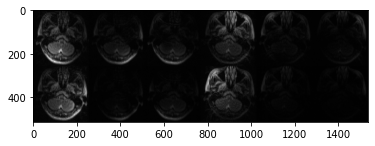

In [9]:
image_data_abs = np.zeros([image_physical_data.shape[0], image_physical_data.shape[1], image_physical_data.shape[-1]], dtype=np.float32)
for i in range(12):
    image_data_abs[:,:,i] = np.rot90(abs(image_physical_data[:,:,i]), -1)
image_data_all = image_data_abs.reshape((image_physical_data.shape[0], image_physical_data.shape[1], 6, 2)).transpose((3, 0, 2, 1)).reshape((2*image_physical_data.shape[0], 6*image_physical_data.shape[1]))
savemat('./data/physical_coil_image.mat', {'Img':image_data_all})
plt.imshow(image_data_all, cmap='gray')
plt.show()

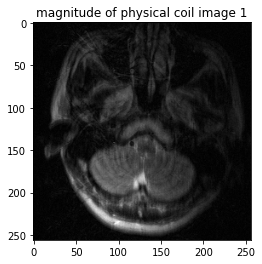

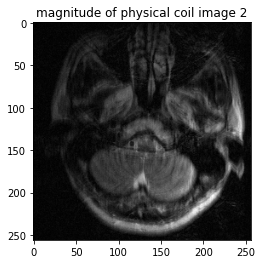

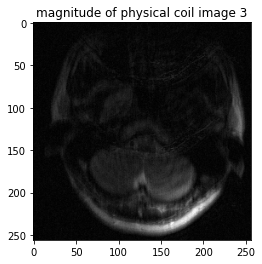

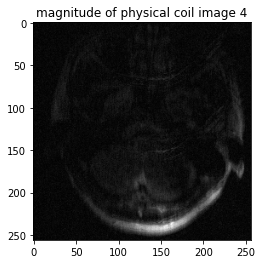

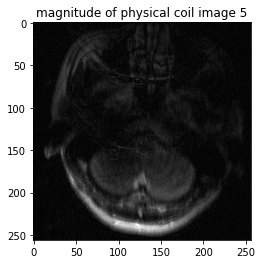

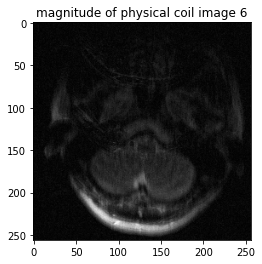

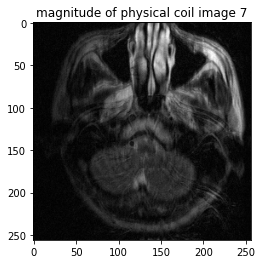

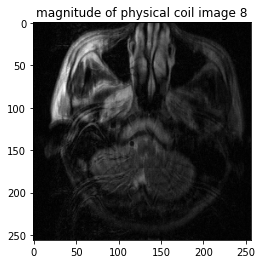

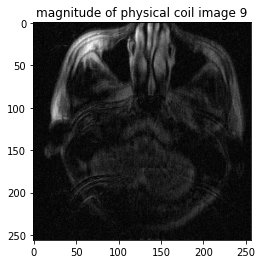

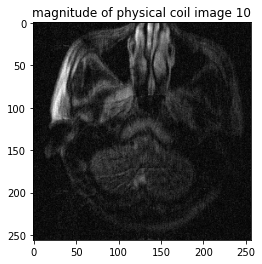

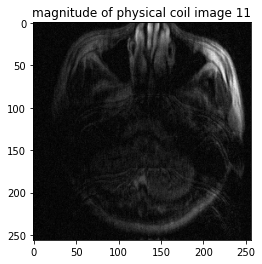

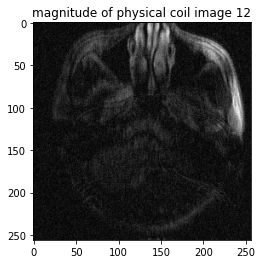

In [10]:
for i in range(12):
    plt.figure()
    plt.imshow(np.rot90(abs(image_physical_data[:,:,i]), -1), cmap='gray')
    plt.title('magnitude of physical coil image {}'.format(i+1))
    plt.show()

## Phase of Physical Coil Images

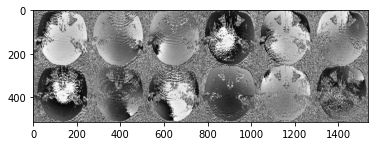

In [11]:
image_data_abs = np.zeros([image_physical_data.shape[0], image_physical_data.shape[1], image_physical_data.shape[-1]], dtype=np.float32)
for i in range(12):
    image_data_abs[:,:,i] = np.rot90(np.angle(image_physical_data[:,:,i]), -1)
image_data_phase_all = image_data_abs.reshape((image_physical_data.shape[0], image_physical_data.shape[1], 6, 2)).transpose((3, 0, 2, 1)).reshape((2*image_physical_data.shape[0], 6*image_physical_data.shape[1]))
savemat('./data/physical_phase_image.mat', {'Img':image_data_phase_all})
plt.imshow(image_data_phase_all, cmap='gray')
plt.show()

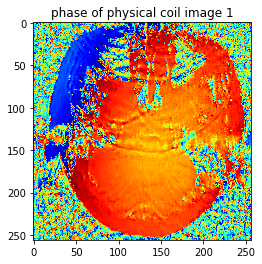

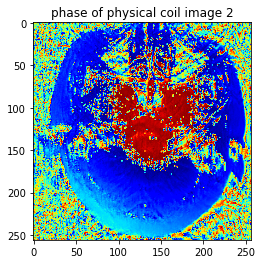

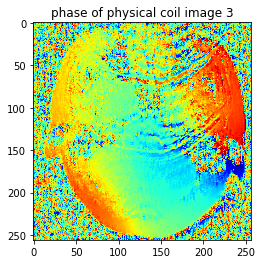

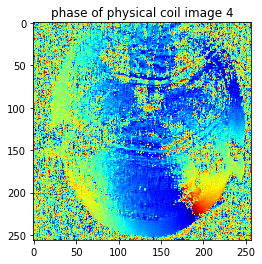

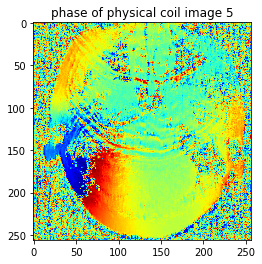

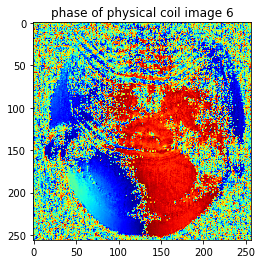

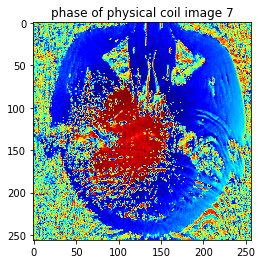

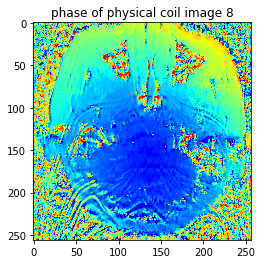

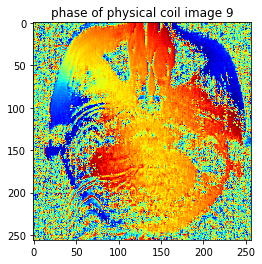

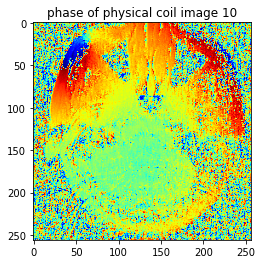

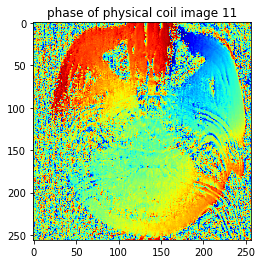

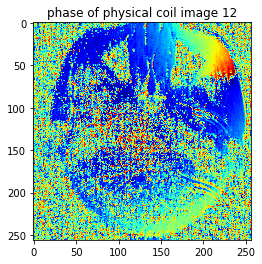

In [12]:
for i in range(12):
    plt.figure()
    plt.imshow(np.rot90(np.angle(image_physical_data[:,:,i]), -1), cmap='jet')
    plt.title('phase of physical coil image {}'.format(i+1))
    plt.show()

## Magnitude of VAN-ICC-K Compressed Virtual Coils

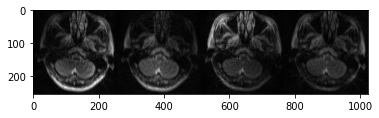

In [13]:
image_virtual_data = loadmat('./data/forward_15.mat')['Img']

image_data_abs = np.zeros([image_physical_data.shape[0], image_physical_data.shape[1], 4], dtype=np.float32)
for i in range(4):
    image_data_abs[:,:,i] = np.rot90(abs(image_virtual_data[:,:,i]), -1)
image_data_van_icc_k_all = image_data_abs.reshape((image_physical_data.shape[0], image_physical_data.shape[1], 4, 1)).transpose((3, 0, 2, 1)).reshape((1*image_physical_data.shape[0], 4*image_physical_data.shape[1]))
savemat('./data/virtual_coil_image.mat', {'Img':image_data_van_icc_k_all})
plt.imshow(image_data_van_icc_k_all, cmap='gray')
plt.show()

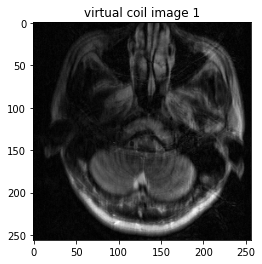

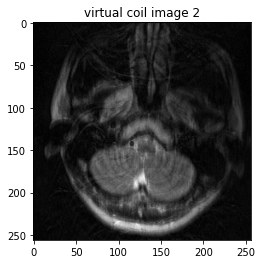

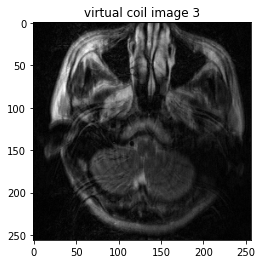

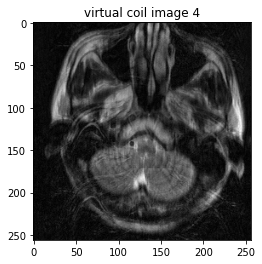

In [14]:
for i in range(4):
    plt.figure()
    plt.imshow(np.rot90(abs(image_virtual_data[:,:,i]), -1), cmap='gray')
    plt.title('virtual coil image {}'.format(i+1))
    plt.show()

## Phase of VAN-ICC-K Compressed Virtual Coils

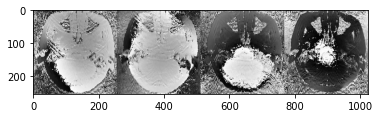

In [15]:
image_data_abs = np.zeros([image_physical_data.shape[0], image_physical_data.shape[1], 4], dtype=np.float32)
for i in range(4):
    image_data_abs[:,:,i] = np.rot90(np.angle(image_virtual_data[:,:,i]), -1)
image_data_van_icc_k_phase_all = image_data_abs.reshape((image_physical_data.shape[0], image_physical_data.shape[1], 4, 1)).transpose((3, 0, 2, 1)).reshape((1*image_physical_data.shape[0], 4*image_physical_data.shape[1]))
savemat('./data/virtual_phase_coil_image.mat', {'Img':image_data_van_icc_k_phase_all})
plt.imshow(image_data_van_icc_k_phase_all, cmap='gray')
plt.show()

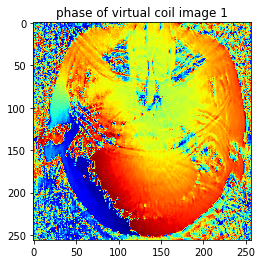

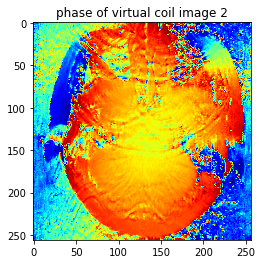

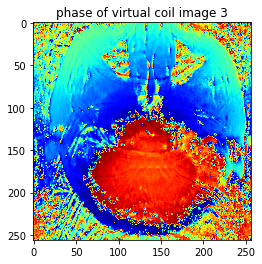

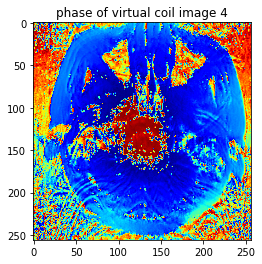

In [16]:
for i in range(4):
    plt.figure()
    plt.imshow(np.rot90(np.angle(image_virtual_data[:,:,i]), -1), cmap='jet')
    plt.title('phase of virtual coil image {}'.format(i+1))
    plt.show()